In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.tree import  DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,cross_val_score

In [71]:
telecom = pd.read_csv("tele_model_data.csv")

In [72]:
telecom

,voice_mail_plan,international_mins,customer_service_calls,international_plan,international_calls,total_charge,churn
0,1,10.0,1,0,3,75.56,0
1,1,13.7,1,0,3,59.24,0
2,0,12.2,0,0,5,62.29,0
3,0,6.6,2,1,7,66.80,0
4,0,10.1,3,1,3,52.09,0
...,...,...,...,...,...,...,...
3328,1,9.9,2,0,6,60.10,0
3329,0,9.6,3,0,4,63.53,0
3330,0,14.1,2,0,6,67.74,0
3331,0,5.0,2,1,10,57.53,0


In [74]:
telecom.describe()

,voice_mail_plan,international_mins,customer_service_calls,international_plan,international_calls,total_charge,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.276628,10.237294,1.562856,0.096910,4.479448,59.449754,0.144914
std,0.447398,2.791840,1.315491,0.295879,2.461214,10.502261,0.352067
min,0.000000,0.000000,0.000000,0.000000,0.000000,22.930000,0.000000
25%,0.000000,8.500000,1.000000,0.000000,3.000000,52.380000,0.000000
50%,0.000000,10.300000,1.000000,0.000000,4.000000,59.470000,0.000000
75%,1.000000,12.100000,2.000000,0.000000,6.000000,66.480000,0.000000
max,1.000000,20.000000,9.000000,1.000000,20.000000,96.150000,1.000000


In [35]:
X = telecom.drop("churn", axis=1)
y = telecom.churn

train_x, test_x, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=y)


In [36]:
y.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [69]:
max_depth = range(1, 11, 1)
print(max_depth)

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "n_estimators"     : [50, 100, 200, 150, 250, 300]  
}


param_grid = dict(max_depth=max_depth)
params.update(param_grid)

range(1, 11)


In [95]:
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, params, cv=kfold)
grid_result = grid_search.fit(train_x, train_y)

In [96]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.981244 using {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}


In [97]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.894972 (0.010215) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50}
0.898347 (0.013372) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}
0.906977 (0.014687) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200}
0.899471 (0.014332) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 150}
0.912229 (0.013730) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 250}
0.919738 (0.014492) with: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 300}
0.929471 (0.012929) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
0.965485 (0.012080) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
0.979746 (0.008743) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
0.977872 (0.008934) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}
0.979746 (0.008743) with: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 250}
0.979371 (0.009517) with: {'learning_rate': 0

In [100]:
grid_result.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}

In [101]:
xgb_clf_imb = XGBClassifier(n_estimators=300, max_depth=3,learning_rate= 0.05)
xgb_clf_imb.fit(train_x,train_y)
predictions = xgb_clf_imb.predict(test_x)

print("Confusion Matrix:")
print(confusion_matrix(test_y, predictions))

print("Classification Report")
print(classification_report(test_y, predictions))


Confusion Matrix:
[[569   1]
 [ 20  77]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       570
           1       0.99      0.79      0.88        97

    accuracy                           0.97       667
   macro avg       0.98      0.90      0.93       667
weighted avg       0.97      0.97      0.97       667



In [102]:
predictions_train = xgb_clf_imb.predict(train_x)

print("Confusion Matrix:")
print(confusion_matrix(train_y, predictions_train))

print("Classification Report")
print(classification_report(train_y, predictions_train))


Confusion Matrix:
[[2280    0]
 [  50  336]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2280
           1       1.00      0.87      0.93       386

    accuracy                           0.98      2666
   macro avg       0.99      0.94      0.96      2666
weighted avg       0.98      0.98      0.98      2666



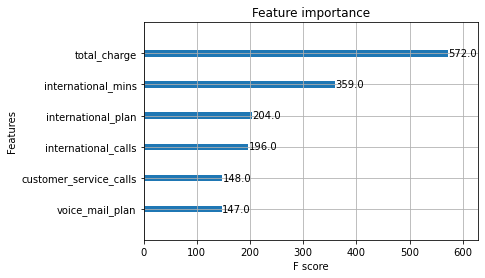

<Figure size 1440x1800 with 0 Axes>

In [103]:
import xgboost as xgb

xgb.plot_importance(xgb_clf_imb)
plt.figure(figsize = (20, 25))
plt.show()

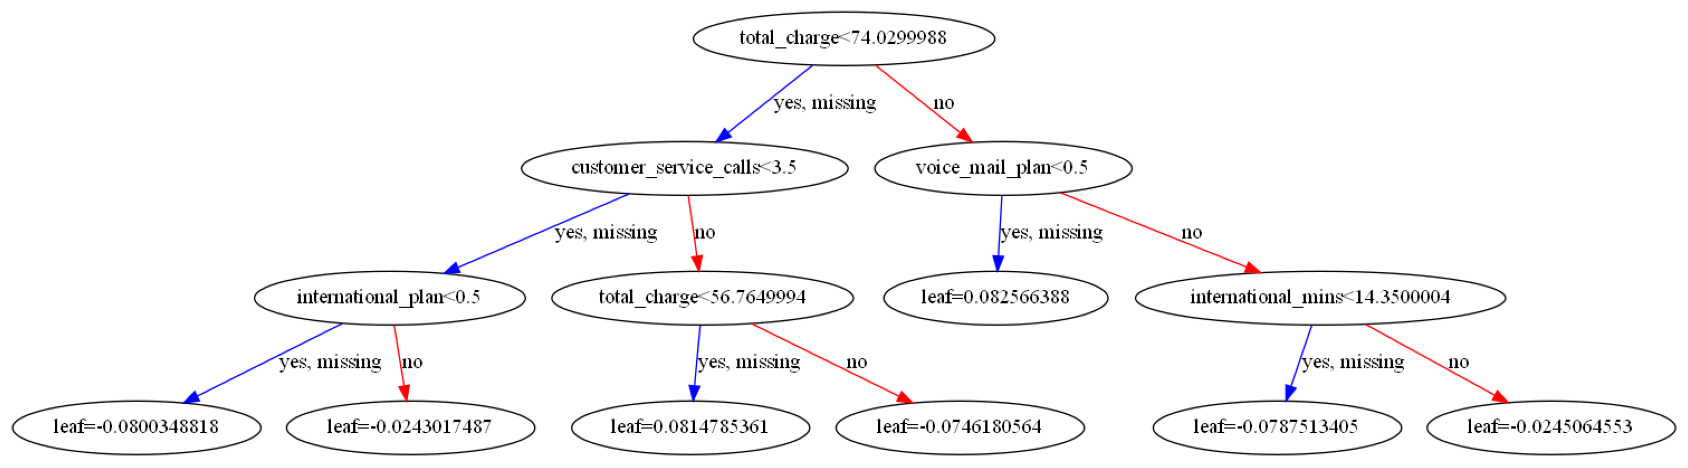

In [104]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xgb_clf_imb, num_trees=4, ax=ax)
plt.show()

## SVM classifier

In [106]:
model_svm = svm.SVC(kernel='poly',gamma='auto', C=2)

In [107]:
model_svm.fit(train_x, train_y)

SVC(C=2, gamma='auto', kernel='poly')

In [108]:
model_svm.score(train_x, train_y)

0.9092273068267067

In [109]:
model_svm.score(test_x, test_y)

0.896551724137931

In [110]:
predictions = model_svm.predict(test_x)

print("Confusion Matrix:")
print(confusion_matrix(test_y, predictions))

print("Classification Report")
print(classification_report(test_y, predictions))


Confusion Matrix:
[[550  20]
 [ 49  48]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       570
           1       0.71      0.49      0.58        97

    accuracy                           0.90       667
   macro avg       0.81      0.73      0.76       667
weighted avg       0.89      0.90      0.89       667



In [111]:
predictions_train = model_svm.predict(train_x)

print("Confusion Matrix:")
print(confusion_matrix(train_y, predictions_train))

print("Classification Report")
print(classification_report(train_y, predictions_train))


Confusion Matrix:
[[2225   55]
 [ 187  199]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2280
           1       0.78      0.52      0.62       386

    accuracy                           0.91      2666
   macro avg       0.85      0.75      0.79      2666
weighted avg       0.90      0.91      0.90      2666



In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [120]:
est = []

est.append(("Logistic Regression",LogisticRegression(max_iter=500)))
est.append(("KNN",KNeighborsClassifier()))
est.append(("SVM",SVC()))
est.append(("NB",GaussianNB()))
est.append(("RF",RandomForestClassifier()))
est.append(("Boosting",XGBClassifier(n_estimators=300, max_depth=3,learning_rate= 0.05)))

In [121]:
for i in range(len(est)):
    model = est[i][1]

    results = cross_val_score(model, train_x, train_y, cv=kfold)

    avg = results.mean()
    sd = results.std()
    
    print("{} || avg: {} || std: {}".format(est[i][0], avg, sd))

Logistic Regression || avg: 0.8608487510912113 || std: 0.013151469412995366
KNN || avg: 0.9099814142096815 || std: 0.010835265242730265
SVM || avg: 0.8593407676494607 || std: 0.005840515937585333
NB || avg: 0.8552223254766128 || std: 0.018389198939088552
RF || avg: 0.9808693081017148 || std: 0.008944627112462992
Boosting || avg: 0.9812438399369208 || std: 0.009185695383882576


In [122]:
for i in range(len(est)):
    model = est[i][1]

    results = cross_val_score(model, test_x, test_y, cv=kfold)

    avg = results.mean()
    sd = results.std()
    
    print("{} || avg: {} || std: {}".format(est[i][0], avg, sd))

Logistic Regression || avg: 0.8650836725463591 || std: 0.021063329277429828
KNN || avg: 0.894979647218453 || std: 0.035615493909488156
SVM || avg: 0.8546132971506106 || std: 0.005906983595940362
NB || avg: 0.8440072365445499 || std: 0.0256373246321575
RF || avg: 0.965445499773858 || std: 0.01672772363556137
Boosting || avg: 0.9669606512890097 || std: 0.01881046254005858


# 

### 

### Random Forest 

In [131]:
param = {"n_estimators":[50,100,150,200],
         "criterion":['gini',"entropy"],
         "max_depth":[1,2,3,4,5,6,7]}

model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid=param,cv=kfold)
grid_result = grid.fit(train_x, train_y)

In [132]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.855593 (0.002828) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 50}
0.855967 (0.002283) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 100}
0.855591 (0.001666) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 150}
0.855967 (0.002283) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 200}
0.894209 (0.023044) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}
0.895717 (0.025836) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
0.898717 (0.021243) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 150}
0.895721 (0.021141) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 200}
0.931344 (0.014704) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}
0.924977 (0.013341) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}
0.928352 (0.010959) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 150}
0.925731 (0.008352) with: {'criterion': 'gini', 'max_depth': 3, 'n_e

In [133]:
grid_result.best_params_

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 150}

In [134]:
model_rf = RandomForestClassifier(criterion='gini', max_depth=6, n_estimators=150)
model_rf.fit(train_x,train_y)
predictions = model_rf.predict(test_x)

print("Confusion Matrix:")
print(confusion_matrix(test_y, predictions))

print("Classification Report")
print(classification_report(test_y, predictions))


Confusion Matrix:
[[570   0]
 [ 20  77]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       570
           1       1.00      0.79      0.89        97

    accuracy                           0.97       667
   macro avg       0.98      0.90      0.93       667
weighted avg       0.97      0.97      0.97       667



In [135]:
predictions_train = model_rf.predict(train_x)

print("Confusion Matrix:")
print(confusion_matrix(train_y, predictions_train))

print("Classification Report")
print(classification_report(train_y, predictions_train))


Confusion Matrix:
[[2280    0]
 [  49  337]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2280
           1       1.00      0.87      0.93       386

    accuracy                           0.98      2666
   macro avg       0.99      0.94      0.96      2666
weighted avg       0.98      0.98      0.98      2666



# Selecting Xgboost as final model 

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper

In [3]:
telecom = pd.read_csv("tele_model_data.csv")

In [4]:
telecom

,voice_mail_plan,international_mins,customer_service_calls,international_plan,international_calls,total_charge,churn
0,1,10.0,1,0,3,75.56,0
1,1,13.7,1,0,3,59.24,0
2,0,12.2,0,0,5,62.29,0
3,0,6.6,2,1,7,66.80,0
4,0,10.1,3,1,3,52.09,0
...,...,...,...,...,...,...,...
3328,1,9.9,2,0,6,60.10,0
3329,0,9.6,3,0,4,63.53,0
3330,0,14.1,2,0,6,67.74,0
3331,0,5.0,2,1,10,57.53,0


In [5]:
telecom['voice_mail_plan'].replace({0:"No",1:'Yes'}, inplace=True)
telecom['international_plan'].replace({0:"No",1:'Yes'}, inplace=True)
# telecom.replace({'churn': {0: "No", 1: "Yes"}}, inplace=True)

In [6]:
telecom

,voice_mail_plan,international_mins,customer_service_calls,international_plan,international_calls,total_charge,churn
0,Yes,10.0,1,No,3,75.56,0
1,Yes,13.7,1,No,3,59.24,0
2,No,12.2,0,No,5,62.29,0
3,No,6.6,2,Yes,7,66.80,0
4,No,10.1,3,Yes,3,52.09,0
...,...,...,...,...,...,...,...
3328,Yes,9.9,2,No,6,60.10,0
3329,No,9.6,3,No,4,63.53,0
3330,No,14.1,2,No,6,67.74,0
3331,No,5.0,2,Yes,10,57.53,0


In [7]:
X = telecom.drop("churn", axis=1)
y = telecom.churn


In [8]:
y.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [9]:
m = DataFrameMapper([(["voice_mail_plan",LabelEncoder()]),(["international_plan",LabelEncoder()])])

In [10]:
classifier = []
classifier.append(("mapper",m))
classifier.append(("model", XGBClassifier(n_estimators=300, max_depth=3,learning_rate= 0.05)))

In [11]:
classifier

[('mapper',
  DataFrameMapper(drop_cols=[],
                  features=[['voice_mail_plan', LabelEncoder()],
                            ['international_plan', LabelEncoder()]])),
 ('model',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=300, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=None,
                reg_alpha=None, reg_lambda=None, ...))]

In [12]:
model= Pipeline(classifier)

In [13]:
model.fit(X,y)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[['voice_mail_plan', LabelEncoder()],
                                           ['international_plan',
                                            LabelEncoder()]])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=300, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [14]:
import pickle
with open(file="Final_model.pkl", mode="wb") as f:
    pickle.dump(model, f)